In [27]:
import os
import numpy as np
from tqdm import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import load_model


In [28]:
image_path = 'test/Water Bodies Dataset/Images/'
mask_path = 'test/Water Bodies Dataset/Masks/'
SIZE = 128

In [29]:
# lists of images and masks names
image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
  path = image_path + image_names[id]
  img = np.asarray(Image.open(path)).astype('float')/255.
  img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
  images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
  path = mask_path + mask_names[id]
  mask = np.asarray(Image.open(path)).astype('float')/255.
  mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
  masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [00:10<00:00, 277.21it/s] 


In [30]:
# Train test split
images_train, images_test, mask_train, mask_test = train_test_split(images, masks, test_size=0.25)

In [31]:
model = load_model('models/11-15.keras')

In [32]:
# Make predictions
predictions = model.predict(images_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [33]:
def mask_threshold(image, threshold=0.25):
  return image>threshold

def plot_results(threshold=0.5):
    k = np.random.randint(len(images_test))
    original_image = images_test[k]
    mask = mask_test[k].reshape(128,128)
    predicted_mask = predictions[k].reshape(128,128)
    threshold_mask = mask_threshold(predicted_mask, threshold=threshold)

    plt.figure(figsize=(15,5))

    plt.subplot(1,4,1)
    plt.imshow(original_image);plt.title('Orginal Image')

    plt.subplot(1,4,2)
    plt.imshow(mask, cmap='gray');plt.title('Original Mask')

    plt.subplot(1,4,3)
    plt.imshow(predicted_mask, cmap='gray');plt.title('Predicted Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(threshold_mask, cmap='gray');plt.title(f'Predicted Mask with cutoff={threshold}')

    plt.tight_layout()
    plt.show()

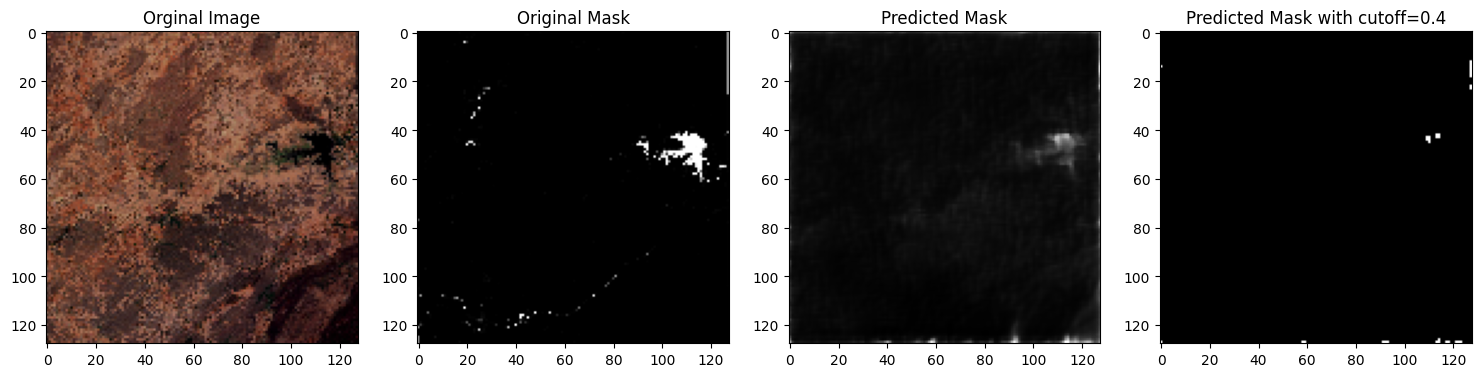

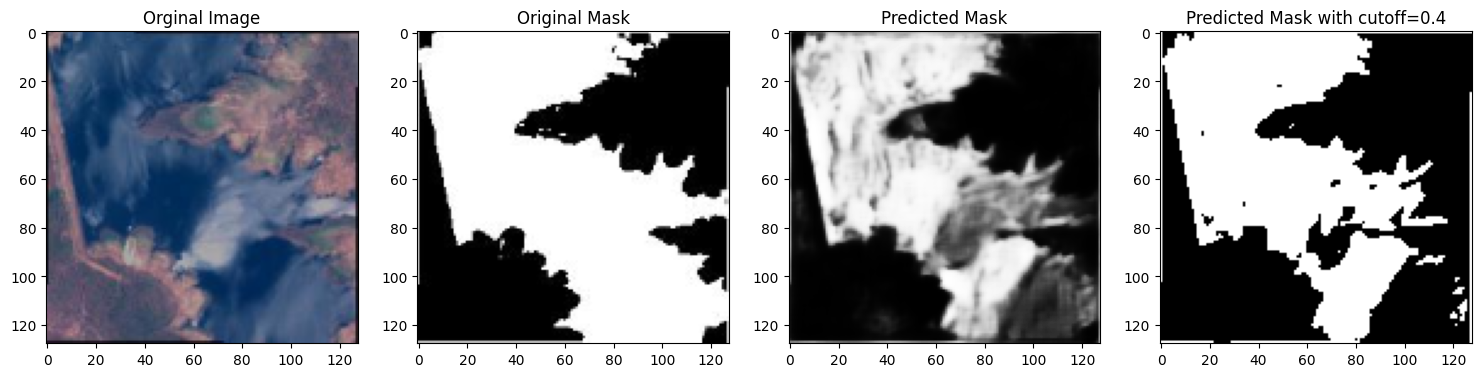

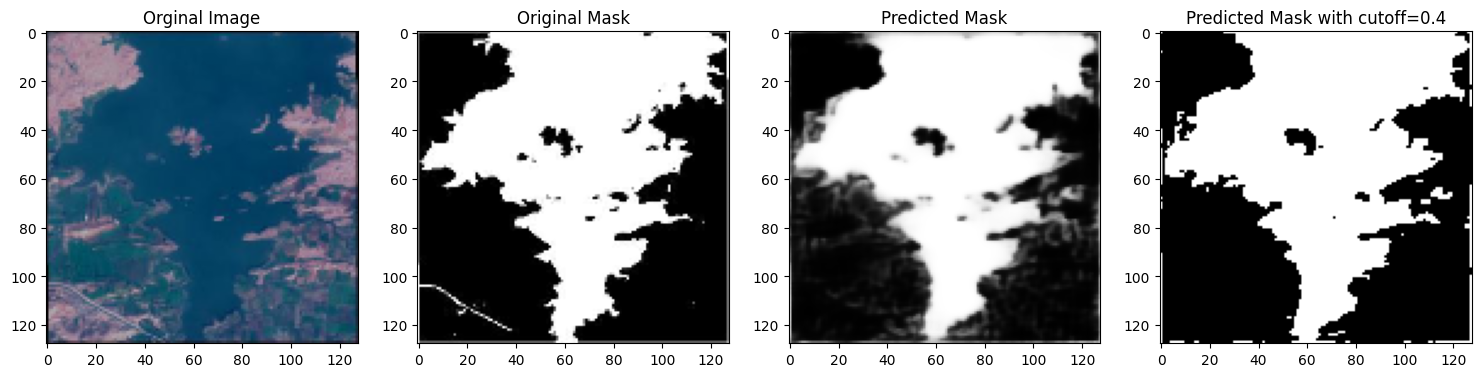

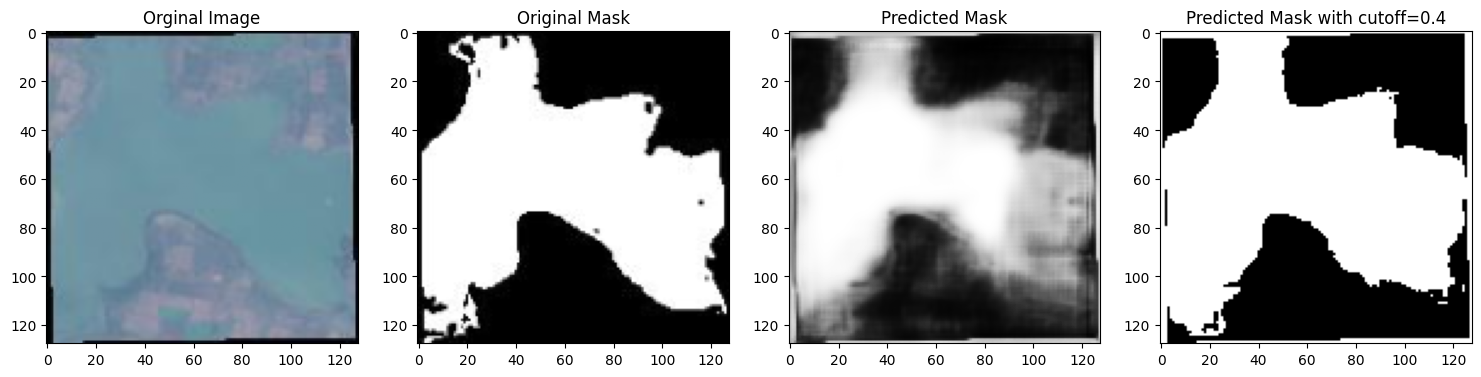

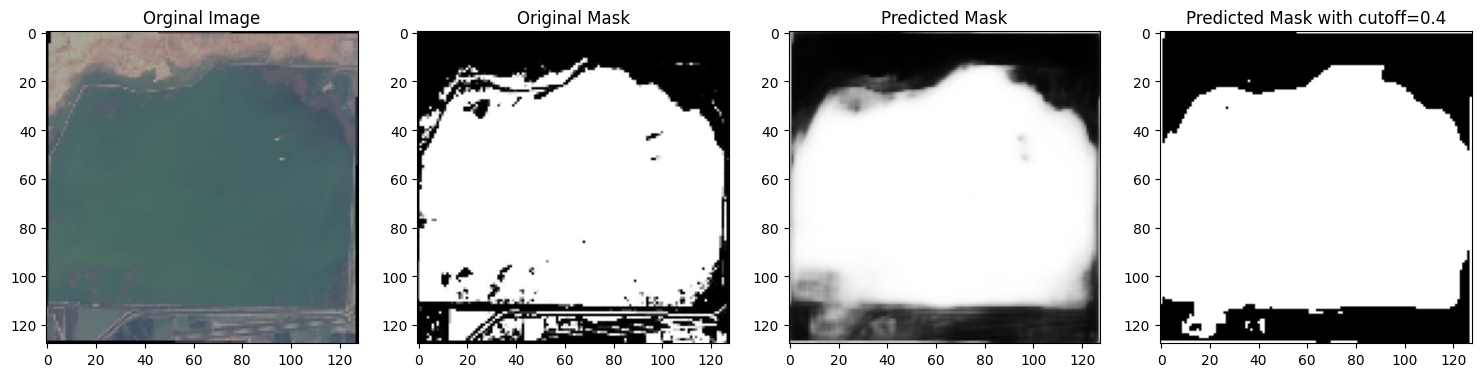

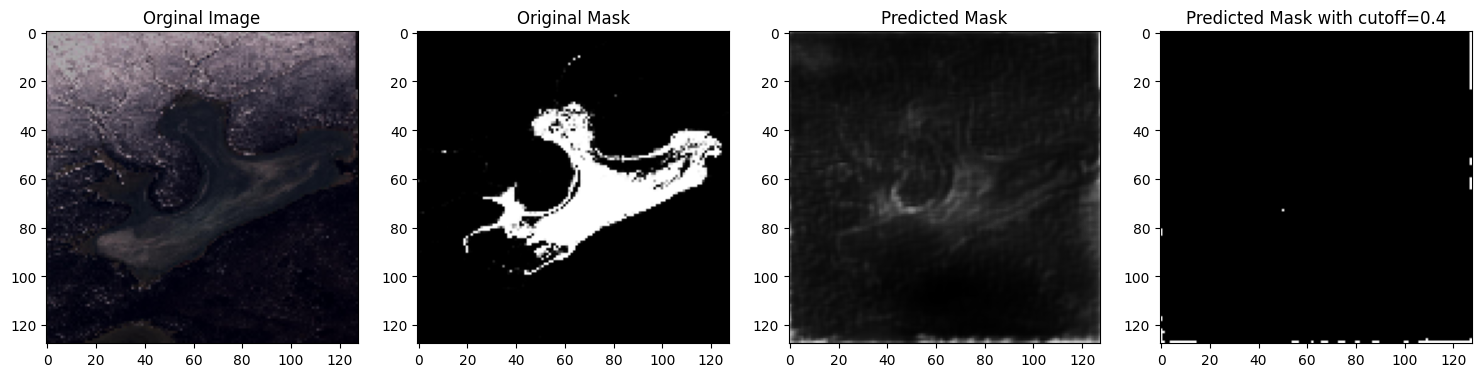

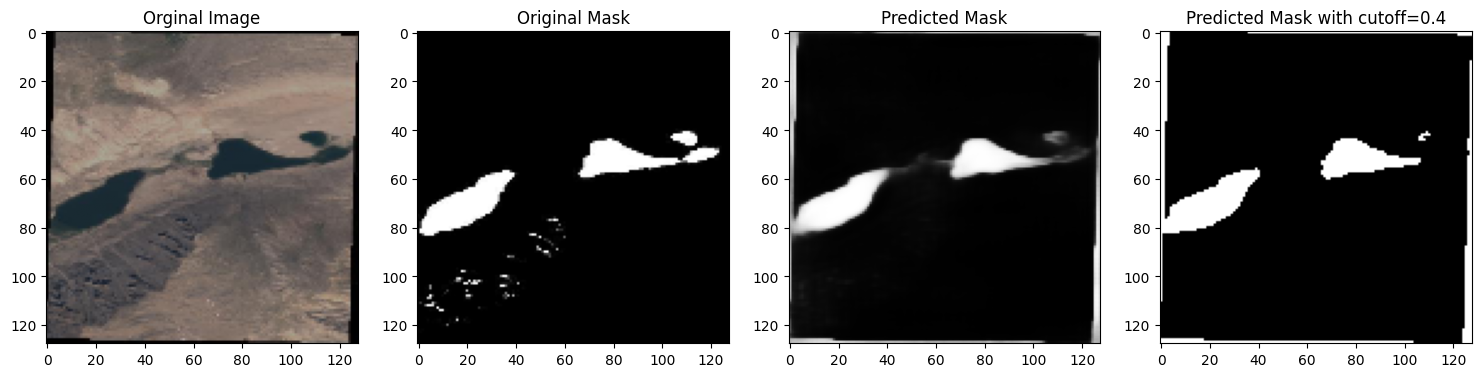

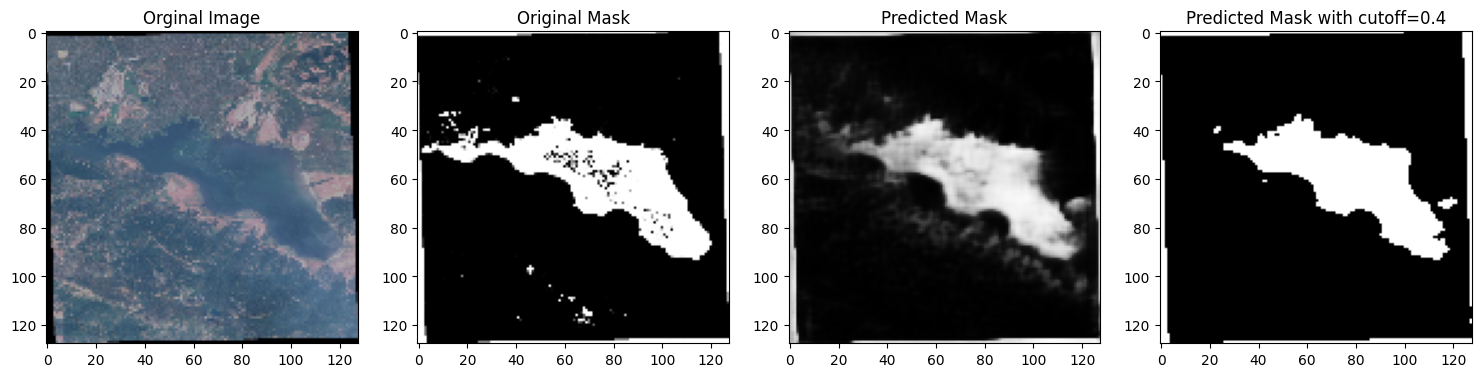

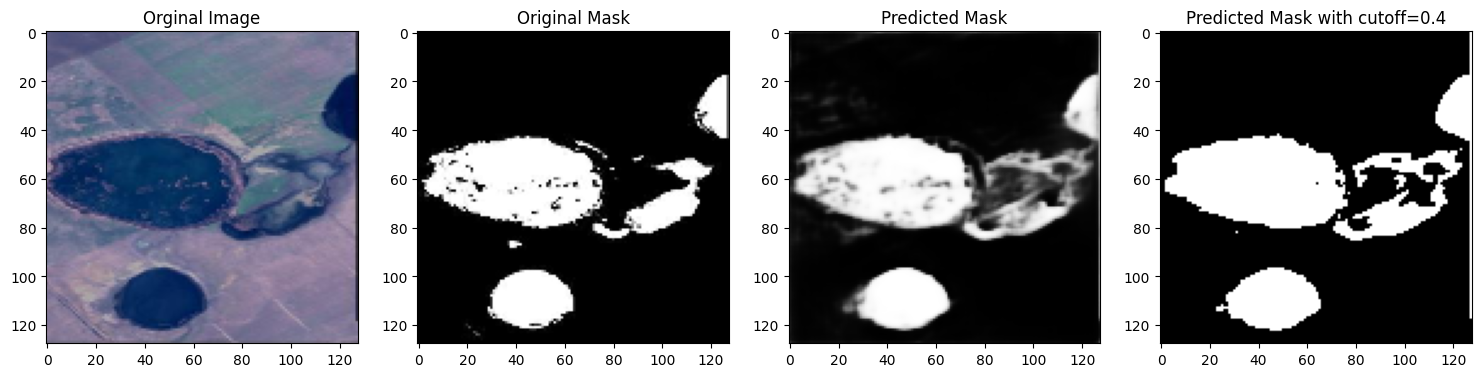

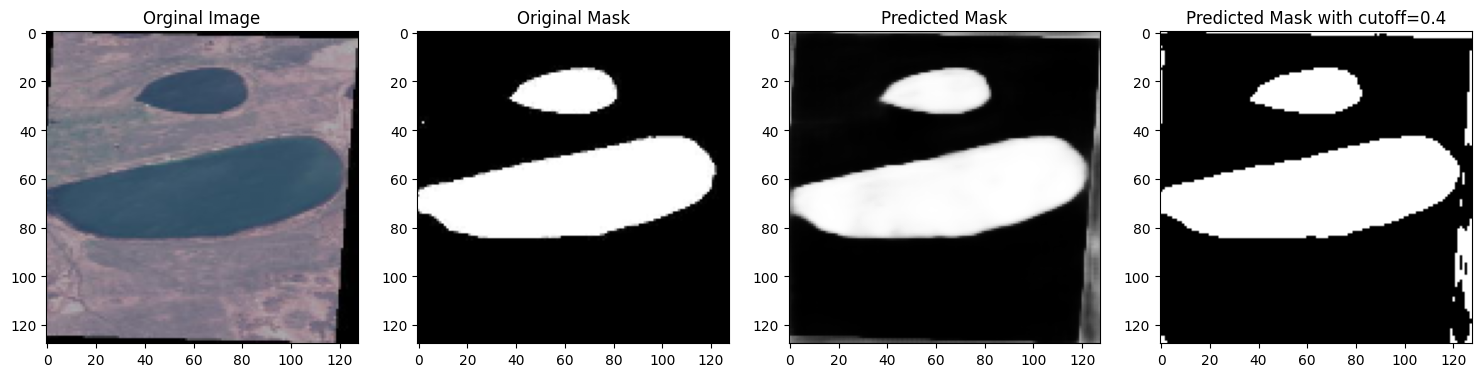

In [34]:
# Plot results on test data
for i in range(10, 20):
  plot_results(threshold=0.4)